<a href="https://colab.research.google.com/github/Stanleyroshan/predictive-analytics-spa-project/blob/main/Spa_Business_Predictive_Analytics_Suite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import warnings
import holidays
import time
import json
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')
try:
    file_path = '/content/drive/MyDrive/bsf_sales_data_202506191432.csv'
    df = pd.read_csv(file_path)
    df['document_date'] = pd.to_datetime(df['document_date'], errors='coerce')
    df_cleaned = df.dropna(subset=['document_date', 'total_inclusive']).copy()
    print(f"Data loaded and cleaned df_cleaned contains {len(df_cleaned)} rows.")

except FileNotFoundError:
    print(f"Source file not found at {file_path}.")
    df_cleaned = None

Mounted at /content/drive
Data loaded and cleaned df_cleaned contains 63575 rows.


In [3]:
if 'df_cleaned' in locals() and df_cleaned is not None:
    daily_sales = df_cleaned[df_cleaned['total_inclusive'] > 0].copy()
    daily_sales['sale_date'] = daily_sales['document_date'].dt.date
    daily_sales = daily_sales.groupby('sale_date')['total_inclusive'].sum().reset_index()
    daily_sales['sale_date'] = pd.to_datetime(daily_sales['sale_date'])

    daily_sales['weekday'] = daily_sales['sale_date'].dt.dayofweek
    daily_sales['month'] = daily_sales['sale_date'].dt.month
    daily_sales['year'] = daily_sales['sale_date'].dt.year
    daily_sales['day_of_year'] = daily_sales['sale_date'].dt.dayofyear
    daily_sales['week_of_year'] = daily_sales['sale_date'].dt.isocalendar().week
    daily_sales['sales_lag_7'] = daily_sales['total_inclusive'].shift(7)
    daily_sales['is_holiday'] = daily_sales['sale_date'].apply(lambda x: x in holidays.ZA())
    daily_sales.dropna(inplace=True)

    X = daily_sales.drop(columns=['sale_date', 'total_inclusive'])
    y = daily_sales['total_inclusive']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

    model1_pro = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    model1_pro.fit(X_train, y_train)
    y_pred = model1_pro.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    smape = 100 / len(y_test) * np.sum(2 * np.abs(y_test - y_pred) / (np.abs(y_test) + np.abs(y_pred) + 1e-8))

    print("\nDaily Sales Prediction")
    print(f"  - MAE:   {mae:,.2f}")
    print(f"  - RMSE:  {rmse:,.2f}")
    print(f"  - SMAPE: {smape:.2f}%")

    result_df1 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    print("\nSample of Daily Actual vs Predicted Sales")
    print(result_df1.head(5).to_string())


Daily Sales Prediction
  - MAE:   22,744.67
  - RMSE:  29,875.53
  - SMAPE: 28.59%

Sample of Daily Actual vs Predicted Sales
        Actual      Predicted
476   72855.50   63057.726562
477   88346.30   74741.460938
478  114291.96  106955.734375
479  100512.16   88698.343750
480   71371.00   64011.531250


In [4]:
if 'df_cleaned' in locals() and df_cleaned is not None:
    df_monthly = df_cleaned.set_index('document_date')
    monthly_sales = df_monthly[df_monthly['total_inclusive'] > 0]['total_inclusive'].resample('M').sum().reset_index()
    monthly_sales = monthly_sales.rename(columns={'document_date': 'month_date', 'total_inclusive': 'monthly_sales'})

    monthly_sales['month_num'] = monthly_sales['month_date'].dt.month
    monthly_sales['year'] = monthly_sales['month_date'].dt.year
    monthly_sales['sales_lag_1'] = monthly_sales['monthly_sales'].shift(1)
    monthly_sales.dropna(inplace=True)

    X = monthly_sales[['month_num', 'year', 'sales_lag_1']]
    y = monthly_sales['monthly_sales']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)

    model2 = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    model2.fit(X_train, y_train)

    y_pred = model2.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    smape = 100 / len(y_test) * np.sum(2 * np.abs(y_test - y_pred) / (np.abs(y_test) + np.abs(y_pred) + 1e-8))

    print("\Monthly Sales Forecasting")
    print(f"  - MAE:   {mae:,.2f}")
    print(f"  - RMSE:  {rmse:,.2f}")
    print(f"  - SMAPE: {smape:.2f}%")

    result_df2 = pd.DataFrame({'Actual_Sales': y_test, 'Predicted_Sales': y_pred})
    print("\nMonthly Actual vs Predicted Sales (Test Set)")
    print(result_df2.to_string())

\Monthly Sales Forecasting
  - MAE:   345,352.57
  - RMSE:  458,498.40
  - SMAPE: 15.38%

Monthly Actual vs Predicted Sales (Test Set)
    Actual_Sales  Predicted_Sales
15    2237995.28       2258684.75
16    2499867.19       2254226.00
17    2919968.72       2251728.00
18    2280855.62       2337829.75
19    1601388.65       2336606.00


In [ ]:
#3 - Total Sales Forecasting
if 'daily_sales' in locals():
    try:
        import holidays
    except ImportError:
        !pip install holidays
        import holidays
    FORECAST_FEATURES = [
        'weekday', 'month', 'year', 'day_of_year',
        'week_of_year', 'sales_lag_7', 'is_holiday'
    ]
    X_full = daily_sales[FORECAST_FEATURES]
    y_full = daily_sales['total_inclusive']
    model_final_forecast = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        early_stopping_rounds=50
    )
    split_index = int(len(X_full) * 0.9)
    X_train_final, X_eval_final = X_full[:split_index], X_full[split_index:]
    y_train_final, y_eval_final = y_full[:split_index], y_full[split_index:]

    model_final_forecast.fit(
        X_train_final, y_train_final,
        eval_set=[(X_eval_final, y_eval_final)],
        verbose=False
    )
    FORECAST_PERIOD_DAYS = 30
    last_known_date = daily_sales['sale_date'].max()
    future_dates = pd.date_range(start=last_known_date + pd.Timedelta(days=1), periods=FORECAST_PERIOD_DAYS, freq='D')
    future_df = pd.DataFrame({'sale_date': future_dates})
    future_df['weekday'] = future_df['sale_date'].dt.dayofweek
    future_df['month'] = future_df['sale_date'].dt.month
    future_df['year'] = future_df['sale_date'].dt.year
    future_df['day_of_year'] = future_df['sale_date'].dt.dayofyear
    future_df['week_of_year'] = future_df['sale_date'].dt.isocalendar().week
    future_df['sales_lag_7'] = daily_sales['total_inclusive'].tail(7).mean() # Use average of last 7 days

    za_holidays = holidays.ZA()
    future_df['is_holiday'] = future_df['sale_date'].apply(lambda x: x in za_holidays).astype(int)
    X_future = future_df[FORECAST_FEATURES]
    future_df['predicted_sales'] = model_final_forecast.predict(X_future)

    total_forecasted_sales = future_df['predicted_sales'].sum()
    future_df['predicted_sales_fmt'] = future_df['predicted_sales'].apply(lambda x: f"{x:,.2f}")
    future_df['day_name'] = future_df['sale_date'].dt.strftime('%A')
    print("        SALES FORECAST REPORT: NEXT 30 DAYS")
    print(f"Forecast Period: {future_dates[0].strftime('%Y-%m-%d')} to {future_dates[-1].strftime('%Y-%m-%d')}")
    print(f"\nTOTAL FORECASTED REVENUE: {total_forecasted_sales:,.2f}")
    report_df = future_df[['sale_date', 'day_name', 'is_holiday', 'predicted_sales_fmt']]
    report_df = report_df.rename(columns={
        'sale_date': 'Date',
        'day_name': 'Day',
        'is_holiday': 'Is Holiday',
        'predicted_sales_fmt': 'Forecasted Sales'
    })
    print(report_df.to_string(index=False))

        SALES FORECAST REPORT: NEXT 30 DAYS
Forecast Period: 2025-06-20 to 2025-07-19

TOTAL FORECASTED REVENUE: 2,393,456.50
      Date       Day  Is Holiday Forecasted Sales
2025-06-20    Friday           0        80,237.02
2025-06-21  Saturday           0       102,868.70
2025-06-22    Sunday           0        90,604.89
2025-06-23    Monday           0        68,030.42
2025-06-24   Tuesday           0        68,135.15
2025-06-25 Wednesday           0        68,835.47
2025-06-26  Thursday           0        71,131.87
2025-06-27    Friday           0        80,237.02
2025-06-28  Saturday           0       103,132.67
2025-06-29    Sunday           0        90,604.89
2025-06-30    Monday           0        68,030.42
2025-07-01   Tuesday           0        68,135.15
2025-07-02 Wednesday           0        68,835.47
2025-07-03  Thursday           0        71,131.87
2025-07-04    Friday           0        80,237.02
2025-07-05  Saturday           0       103,132.67
2025-07-06    Sunday    

In [ ]:
#4 - Top-selling Product Classification
if 'df_cleaned' in locals():
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score, classification_report
    from xgboost import XGBClassifier # Note: We use XGBClassifier for classification tasks
    sales_data = df_cleaned[df_cleaned['total_inclusive'] > 0].copy()
    product_performance = sales_data.groupby('description').agg(
        total_revenue=('total_inclusive', 'sum'),
        times_sold=('description', 'count'),
        avg_price=('total_inclusive', 'mean'),
        item_type=('item_type', 'first'),
        category=('category', 'first'),
        avg_duration=('duration', 'mean')
    ).reset_index()
    revenue_threshold = product_performance['total_revenue'].quantile(0.80)
    product_performance['is_top_seller'] = (product_performance['total_revenue'] >= revenue_threshold).astype(int)
    features_to_use = ['avg_price', 'avg_duration', 'item_type', 'category']
    model_data = product_performance[features_to_use + ['is_top_seller']].copy()
    model_data['category'] = model_data['category'].fillna('Unknown')
    model_data_encoded = pd.get_dummies(model_data, columns=['item_type', 'category'], drop_first=True)
    X = model_data_encoded.drop(columns=['is_top_seller'])
    y = model_data_encoded['is_top_seller']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    model4_classifier = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)
    model4_classifier.fit(X_train, y_train)
    y_pred = model4_classifier.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=['Not a Top Seller', 'Top Seller'])
    accuracy = accuracy_score(y_test, y_pred)

    print("        TOP-SELLING PRODUCT CLASSIFICATION REPORT")
    print(f"Revenue Threshold for a Top Seller: {revenue_threshold:,.2f}")
    print(f"Total Unique Products Analyzed: {len(product_performance)}")
    print(f"Number of Top Sellers: {product_performance['is_top_seller'].sum()} ({product_performance['is_top_seller'].mean():.1%})")
    print("\nModel Performance (on Unseen Test Data)")
    print(f"\nOverall Accuracy: {accuracy:.2%}")
    print("\nThis means the model correctly predicted whether a product would be a")
    print("top seller or not on the test set with this level of accuracy.")
    print("\nDetailed Classification Report")
    print(report)

        TOP-SELLING PRODUCT CLASSIFICATION REPORT
Revenue Threshold for a Top Seller: 9,560.11
Total Unique Products Analyzed: 2864
Number of Top Sellers: 573 (20.0%)

Model Performance (on Unseen Test Data)

Overall Accuracy: 87.15%

This means the model correctly predicted whether a product would be a
top seller or not on the test set with this level of accuracy.

Detailed Classification Report
                  precision    recall  f1-score   support

Not a Top Seller       0.89      0.95      0.92       573
      Top Seller       0.74      0.55      0.63       143

        accuracy                           0.87       716
       macro avg       0.82      0.75      0.78       716
    weighted avg       0.86      0.87      0.86       716



In [ ]:
#5 - Customer Loyalty Classification (Refined & Corrected)
if 'df_cleaned' in locals():
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score, classification_report
    from xgboost import XGBClassifier
    import datetime as dt
    sales_data = df_cleaned[df_cleaned['total_inclusive'] > 0].copy()
    sales_data['document_date'] = pd.to_datetime(sales_data['document_date'])
    snapshot_date = sales_data['document_date'].max() + dt.timedelta(days=1)
    customer_data = sales_data.groupby('client_id').agg(
        recency=('document_date', lambda date: (snapshot_date - date.max()).days),
        frequency=('document_date', 'count'),
        monetary=('total_inclusive', 'sum')
    ).reset_index()
    customer_data['r_score'] = pd.qcut(customer_data['recency'], q=4, labels=False, duplicates='drop')
    customer_data['f_score'] = pd.qcut(customer_data['frequency'], q=4, labels=False, duplicates='drop')
    customer_data['m_score'] = pd.qcut(customer_data['monetary'], q=4, labels=False, duplicates='drop')
    customer_data['r_score'] = 3 - customer_data['r_score']
    customer_data['rfm_score'] = customer_data['r_score'] + customer_data['f_score'] + customer_data['m_score']
    loyalty_threshold = customer_data['rfm_score'].quantile(0.75)
    customer_data['is_loyal'] = (customer_data['rfm_score'] >= loyalty_threshold).astype(int)
    X = customer_data[['recency', 'frequency', 'monetary']]
    y = customer_data['is_loyal']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

    model5_loyalty = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)
    model5_loyalty.fit(X_train, y_train)
    y_pred = model5_loyalty.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=['Not Loyal', 'Loyal'])
    accuracy = accuracy_score(y_test, y_pred)
    print("        CUSTOMER LOYALTY CLASSIFICATION REPORT")
    print("RFM (Recency, Frequency, Monetary) score.")
    print(f"\nTotal Unique Customers Analyzed: {len(customer_data)}")
    print(f"Number of Customers Classified as Loyal: {customer_data['is_loyal'].sum()} ({customer_data['is_loyal'].mean():.1%})")
    print("\nModel Performance (on Unseen Test Data)")
    print(f"\nOverall Accuracy: {accuracy:.2%}")

        CUSTOMER LOYALTY CLASSIFICATION REPORT
RFM (Recency, Frequency, Monetary) score.

Total Unique Customers Analyzed: 22356
Number of Customers Classified as Loyal: 7281 (32.6%)

Model Performance (on Unseen Test Data)

Overall Accuracy: 99.86%


In [ ]:
#6 - Sales Anomaly Prediction Model
if 'daily_sales' in locals():
    from sklearn.ensemble import IsolationForest
    from sklearn.model_selection import train_test_split
    from xgboost import XGBClassifier
    from sklearn.metrics import classification_report, accuracy_score
    iso_forest = IsolationForest(contamination=0.10, random_state=42) # Let's assume 10% of days are anomalous
    daily_sales['is_anomaly_label'] = iso_forest.fit_predict(daily_sales[['total_inclusive']])
    daily_sales['is_anomaly_label'] = daily_sales['is_anomaly_label'].apply(lambda x: 1 if x == -1 else 0)
    features = ['weekday', 'month', 'year', 'day_of_year', 'week_of_year', 'is_holiday']
    X = daily_sales[features]
    y = daily_sales['is_anomaly_label']
    split_index = int(len(X) * 0.8)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    anomaly_predictor = XGBClassifier(objective='binary:logistic', random_state=42)
    anomaly_predictor.fit(X_train, y_train)
    y_pred = anomaly_predictor.predict(X_test)
    print("       SALES ANOMALY PREDICTION REPORT")
    print("\n   Model Performance (on recent, unseen data)")
    print(f"\nModel Accuracy: {accuracy_score(y_test, y_pred):.2%}")
    print(classification_report(y_test, y_pred, target_names=['Predicted: Normal Day', 'Predicted: ANOMALY']))
    last_known_date = daily_sales['sale_date'].max()
    tomorrow = last_known_date + pd.Timedelta(days=1)

    import holidays
    za_holidays = holidays.ZA()

    future_day_features = pd.DataFrame([{
        'weekday': tomorrow.dayofweek,
        'month': tomorrow.month,
        'year': tomorrow.year,
        'day_of_year': tomorrow.dayofyear,
        'week_of_year': tomorrow.isocalendar().week,
        'is_holiday': tomorrow in za_holidays
    }])

    prediction = anomaly_predictor.predict(future_day_features)[0]
    prediction_proba = anomaly_predictor.predict_proba(future_day_features)[0][1]

       SALES ANOMALY PREDICTION REPORT

   Model Performance (on recent, unseen data)

Model Accuracy: 81.36%
                       precision    recall  f1-score   support

Predicted: Normal Day       0.83      0.97      0.90        99
   Predicted: ANOMALY       0.00      0.00      0.00        19

             accuracy                           0.81       118
            macro avg       0.42      0.48      0.45       118
         weighted avg       0.70      0.81      0.75       118



In [ ]:
#7 - Customer Segment Prediction Model (Corrected & Professional)
if 'df_cleaned' in locals():
    from sklearn.cluster import KMeans
    from sklearn.preprocessing import StandardScaler, OneHotEncoder
    from sklearn.impute import SimpleImputer
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import train_test_split
    from xgboost import XGBClassifier
    from sklearn.metrics import classification_report, accuracy_score
    import pandas as pd
    import datetime as dt
    sales_data = df_cleaned[df_cleaned['total_inclusive'] > 0].copy()
    sales_data['document_date'] = pd.to_datetime(sales_data['document_date'])
    snapshot_date = sales_data['document_date'].max() + pd.to_timedelta(1, 'D')

    customer_rfm = sales_data.groupby('client_id').agg(
        recency=('document_date', lambda date: (snapshot_date - date.max()).days),
        frequency=('document_date', 'count'),
        monetary=('total_inclusive', 'sum')
    ).reset_index()
    rfm_features = customer_rfm[['recency', 'frequency', 'monetary']]

    imputer = SimpleImputer(strategy='median')
    rfm_imputed = imputer.fit_transform(rfm_features)

    scaler = StandardScaler()
    rfm_scaled = scaler.fit_transform(rfm_imputed)

    kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init=10)
    customer_rfm['final_segment'] = kmeans.fit_predict(rfm_scaled)
    first_transaction_date = sales_data.groupby('client_id')['document_date'].min().reset_index()
    first_day_transactions = pd.merge(sales_data, first_transaction_date, on=['client_id', 'document_date'])

    first_day_features = first_day_transactions.groupby('client_id').agg(
        first_day_spend=('total_inclusive', 'sum'),
        first_day_items=('quantity', 'sum'),
        first_item_category=('category', 'first'),
        customer_source=('source', 'first')
    ).reset_index()
    predictive_df = pd.merge(first_day_features, customer_rfm[['client_id', 'final_segment']], on='client_id')

    X = predictive_df.drop(columns=['client_id', 'final_segment'])
    y = predictive_df['final_segment']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    categorical_features = ['first_item_category', 'customer_source']
    numeric_features = ['first_day_spend', 'first_day_items']
    X_train[categorical_features] = X_train[categorical_features].fillna('Unknown')
    X_test[categorical_features] = X_test[categorical_features].fillna('Unknown')

    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

    segment_predictor = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', use_label_encoder=False, random_state=42))
    ])

    segment_predictor.fit(X_train, y_train)
    y_pred = segment_predictor.predict(X_test)
    print("                    CUSTOMER SEGMENT PREDICTION REPORT")
    print("\nBUSINESS GOAL: ...")
    print("\n   Model Performance (on unseen test data)")
    print(f"\nModel Accuracy: {accuracy_score(y_test, y_pred):.2%}")
    print(classification_report(y_test, y_pred, target_names=['Segment 0', 'Segment 1', 'Segment 2', 'Segment 3']))
    new_customer_data = pd.DataFrame([{
        'first_day_spend': 1200,
        'first_day_items': 1,
        'first_item_category': 'Massage Collection',
        'customer_source': 'Hotel Guest'
    }])

    prediction_proba = segment_predictor.predict_proba(new_customer_data)[0]
    predicted_segment = prediction_proba.argmax()

                    CUSTOMER SEGMENT PREDICTION REPORT

BUSINESS GOAL: ...

   Model Performance (on unseen test data)

Model Accuracy: 64.18%
              precision    recall  f1-score   support

   Segment 0       0.62      0.74      0.68      2665
   Segment 1       0.65      0.57      0.61      2468
   Segment 2       0.50      0.16      0.24        19
   Segment 3       0.82      0.49      0.61       437

    accuracy                           0.64      5589
   macro avg       0.65      0.49      0.53      5589
weighted avg       0.65      0.64      0.64      5589



In [ ]:
#8 - Product Demand Forecasting (Client-Ready Version)
if 'df_cleaned' in locals():
    from sklearn.model_selection import train_test_split
    from xgboost import XGBRegressor
    from sklearn.metrics import mean_absolute_error
    sales_data = df_cleaned[df_cleaned['total_inclusive'] > 0].copy()
    sales_data['document_date'] = pd.to_datetime(sales_data['document_date'])
    product_weekly_demand = sales_data.groupby([
        'description',
        pd.Grouper(key='document_date', freq='W-MON', label='left', closed='left')
    ]).agg(
        quantity_sold=('quantity', 'sum'),
        avg_price=('total_inclusive', 'mean')
    ).reset_index()
    product_weekly_demand['month'] = product_weekly_demand['document_date'].dt.month
    product_weekly_demand['week_of_year'] = product_weekly_demand['document_date'].dt.isocalendar().week
    product_weekly_demand.sort_values(by=['description', 'document_date'], inplace=True)
    product_weekly_demand['sales_lag_4_weeks'] = product_weekly_demand.groupby('description')['quantity_sold'].shift(4)
    product_weekly_demand.fillna(0, inplace=True)

    model_data = pd.get_dummies(product_weekly_demand, columns=['description'], drop_first=True)

    X = model_data.drop(columns=['document_date', 'quantity_sold'])
    y = model_data['quantity_sold']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

    model8_demand = XGBRegressor(n_estimators=500, learning_rate=0.05, random_state=42, early_stopping_rounds=30)
    model8_demand.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    top_products = sales_data['description'].value_counts().nlargest(15).index
    last_date = product_weekly_demand['document_date'].max()
    future_weeks = pd.date_range(start=last_date + dt.timedelta(weeks=1), periods=4, freq='W-MON')

    future_forecasts = []
    for product in top_products:
        for week_start in future_weeks:
            last_known_data = product_weekly_demand[product_weekly_demand['description'] == product].tail(1)
            if not last_known_data.empty:
                lag_value = last_known_data['sales_lag_4_weeks'].iloc[0]
                future_forecasts.append({
                    'description': product,
                    'document_date': week_start,
                    'month': week_start.month,
                    'week_of_year': week_start.isocalendar().week,
                    'sales_lag_4_weeks': lag_value,
                    'avg_price': last_known_data['avg_price'].iloc[0]
                })

    future_df = pd.DataFrame(future_forecasts)
    future_df_encoded = pd.get_dummies(future_df, columns=['description'])
    missing_cols = set(X.columns) - set(future_df_encoded.columns)
    for c in missing_cols:
        future_df_encoded[c] = 0
    future_df_encoded = future_df_encoded[X.columns]
    future_df['forecasted_demand'] = model8_demand.predict(future_df_encoded)
    future_df['forecasted_demand'] = future_df['forecasted_demand'].round().astype(int)
    future_df.loc[future_df['forecasted_demand'] < 0, 'forecasted_demand'] = 0
    report_pivot = future_df.pivot_table(
        index='description',
        columns='document_date',
        values='forecasted_demand'
    )
    report_pivot['total_forecast'] = report_pivot.sum(axis=1)
    report_pivot = report_pivot.sort_values(by='total_forecast', ascending=False).drop(columns='total_forecast')
    report_pivot.columns = [d.strftime('%Y-%m-%d') for d in report_pivot.columns]

    print("            WEEKLY PRODUCT & SERVICE DEMAND FORECAST")
    print(report_pivot.to_string())

            WEEKLY PRODUCT & SERVICE DEMAND FORECAST
                                                 2025-06-23  2025-06-30  2025-07-07  2025-07-14
description                                                                                    
Aroma Wellbeing Massage  - Stress Release 60min         9.0         9.0        11.0        11.0
Kurhula Body Ritual                                     9.0         9.0         9.0         9.0
CBD Relax & Unwind - 60min                              8.0         8.0         8.0         8.0
Classic Swedish Massage - 60min                         6.0         6.0         6.0         6.0
Aroma Wellbeing: Stress Release - 60min                 6.0         6.0         6.0         6.0
Classic Swedish Massage 60mins                          5.0         5.0         7.0         7.0
Aroma Wellbeing: Muscle Ease - 60min                    6.0         6.0         6.0         6.0
Deep Tissue Massage 60mins                              6.0         6.0         6.0

             PRODUCT PRICING DIAGNOSTIC & RECOMMENDATION
For Product: Classic Swedish Massage - 60min
DIAGNOSIS: OPPORTUNITY TO INCREASE PRICE: The data suggests you can increase the price from your current average of ~718.15 to 9,000.00 to maximize revenue.


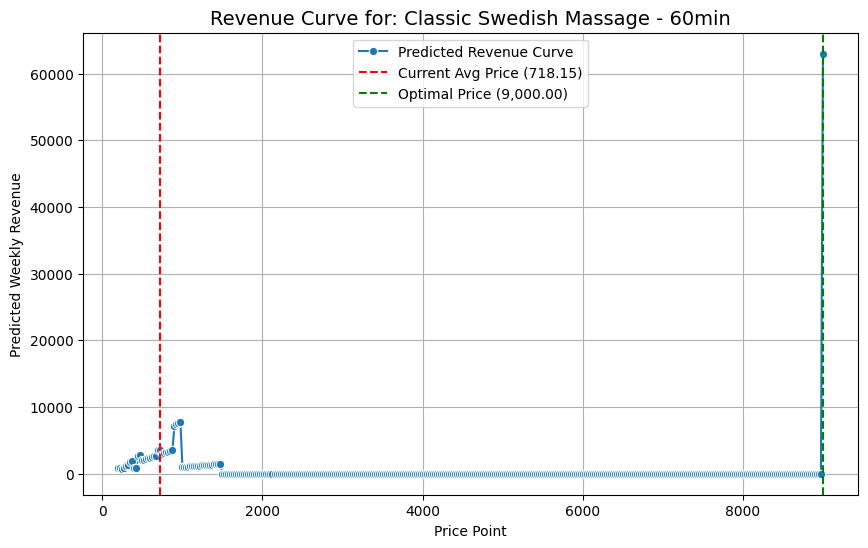

             PRODUCT PRICING DIAGNOSTIC & RECOMMENDATION
For Product: Deep Tissue Massage - 60min
DIAGNOSIS: OPPORTUNITY TO INCREASE PRICE: The data suggests you can increase the price from your current average of ~1,038.46 to 5,100.00 to maximize revenue.


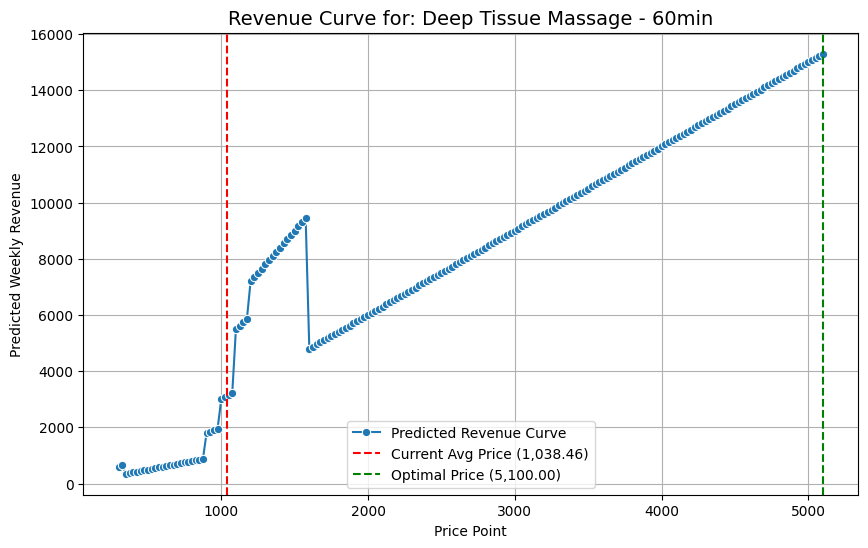

             PRODUCT PRICING DIAGNOSTIC & RECOMMENDATION
For Product: Pressure Point Foot Massage
DIAGNOSIS: OPPORTUNITY TO INCREASE PRICE: The data suggests you can increase the price from your current average of ~564.89 to 725.00 to maximize revenue.


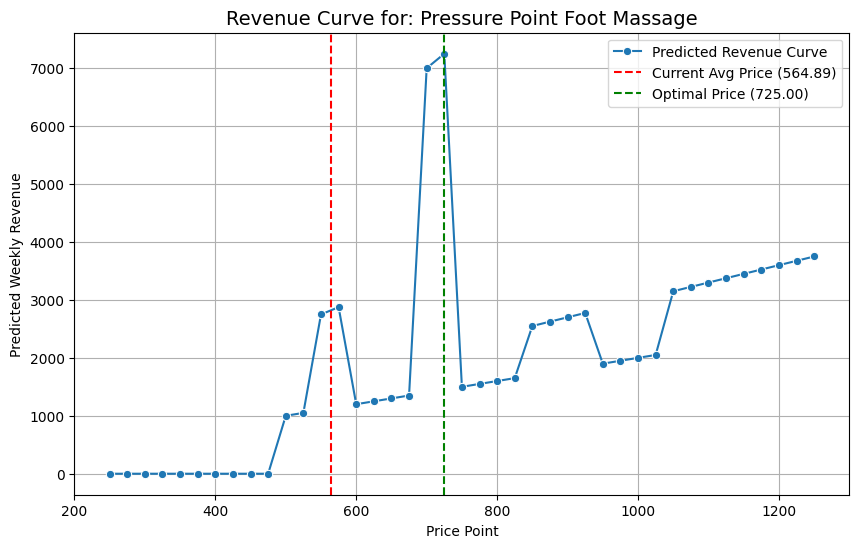

      FINAL CHATBOT KNOWLEDGE BASE: PRICE OPTIMIZATION
[
  {
    "product_name": "Classic Swedish Massage - 60min",
    "status": "Success",
    "chatbot_summary": "OPPORTUNITY TO INCREASE PRICE: The data suggests you can increase the price from your current average of ~718.15 to 9,000.00 to maximize revenue."
  },
  {
    "product_name": "Deep Tissue Massage - 60min",
    "status": "Success",
    "chatbot_summary": "OPPORTUNITY TO INCREASE PRICE: The data suggests you can increase the price from your current average of ~1,038.46 to 5,100.00 to maximize revenue."
  },
  {
    "product_name": "Pressure Point Foot Massage",
    "status": "Success",
    "chatbot_summary": "OPPORTUNITY TO INCREASE PRICE: The data suggests you can increase the price from your current average of ~564.89 to 725.00 to maximize revenue."
  }
]


In [ ]:
#9: Scalable Pricing Engine
if 'df_cleaned' in locals():
    from xgboost import XGBRegressor
    import numpy as np
    import pandas as pd
    import json
    import datetime as dt
    import matplotlib.pyplot as plt
    import seaborn as sns
    def generate_pricing_report(product_name: str, df: pd.DataFrame, generate_plot=True):
        product_data = df[df['description'] == product_name].copy()
        product_data = product_data[product_data['total_inclusive'] > 0]
        if len(product_data) < 50 or product_data['total_inclusive'].nunique() < 5:
            return {"product_name": product_name, "status": "Failed", "chatbot_summary": "Analysis failed due to insufficient historical data for this product."}
        product_data['document_date'] = pd.to_datetime(product_data['document_date'])
        product_data['price_bucket'] = (product_data['total_inclusive'] / 50).round() * 50

        weekly_demand = product_data.groupby(['price_bucket', pd.Grouper(key='document_date', freq='W-MON')]).agg(quantity_sold=('quantity', 'sum')).reset_index()
        weekly_demand['month'] = weekly_demand['document_date'].dt.month
        weekly_demand['week_of_year'] = weekly_demand['document_date'].dt.isocalendar().week

        X = weekly_demand[['price_bucket', 'month', 'week_of_year']]
        y = weekly_demand['quantity_sold']
        demand_model = XGBRegressor(n_estimators=100, random_state=42).fit(X, y)

        min_p = int(weekly_demand['price_bucket'].min())
        max_p = int(weekly_demand['price_bucket'].max())

        if min_p >= max_p:
            return {"product_name": product_name, "status": "Failed", "chatbot_summary": "Analysis failed because the price for this product has not varied enough."}

        price_range = np.arange(min_p, max_p + 25, 25)
        sim_df = pd.DataFrame({'price_bucket': price_range, 'month': 6, 'week_of_year': 26})
        sim_df['predicted_demand'] = demand_model.predict(sim_df).round().astype(int)
        sim_df.loc[sim_df['predicted_demand'] < 0, 'predicted_demand'] = 0
        sim_df['predicted_revenue'] = sim_df['price_bucket'] * sim_df['predicted_demand']

        optimal_point = sim_df.loc[sim_df['predicted_revenue'].idxmax()]
        optimal_price = optimal_point['price_bucket']
        current_avg_price = product_data['total_inclusive'].mean()

        if abs(current_avg_price - optimal_price) < (current_avg_price * 0.1):
             diagnosis = "EXCELLENT PRICING: Your current average price is already very close to the optimal point."
        elif current_avg_price < optimal_price:
             diagnosis = f"OPPORTUNITY TO INCREASE PRICE: The data suggests you can increase the price from your current average of ~{current_avg_price:,.2f} to {optimal_price:,.2f} to maximize revenue."
        else:
             diagnosis = f"OPPORTUNITY TO DECREASE PRICE: Your current average price is likely too high. The data suggests you can increase total revenue by lowering the price to {optimal_price:,.2f}."
        if generate_plot:
            print("             PRODUCT PRICING DIAGNOSTIC & RECOMMENDATION")
            print(f"For Product: {product_name}")
            print(f"DIAGNOSIS: {diagnosis}")
            plt.figure(figsize=(10, 6))
            sns.lineplot(x='price_bucket', y='predicted_revenue', data=sim_df, marker='o', label='Predicted Revenue Curve')
            plt.axvline(x=current_avg_price, color='red', linestyle='--', label=f'Current Avg Price ({current_avg_price:,.2f})')
            plt.axvline(x=optimal_price, color='green', linestyle='--', label=f'Optimal Price ({optimal_price:,.2f})')
            plt.title(f'Revenue Curve for: {product_name}', fontsize=14)
            plt.xlabel('Price Point'); plt.ylabel('Predicted Weekly Revenue'); plt.legend(); plt.grid(True)
            plt.show()
        return {
            "product_name": product_name,
            "status": "Success",
            "chatbot_summary": diagnosis
        }
    PRODUCTS_TO_ANALYZE = [
        "Classic Swedish Massage - 60min",
        "Deep Tissue Massage - 60min",
        "Pressure Point Foot Massage"
    ]
    chatbot_knowledge_base = []

    for product in PRODUCTS_TO_ANALYZE:
        report = generate_pricing_report(product, df_cleaned, generate_plot=True)
        if report:
            chatbot_knowledge_base.append(report)

    print("      FINAL CHATBOT KNOWLEDGE BASE: PRICE OPTIMIZATION")
    print(json.dumps(chatbot_knowledge_base, indent=2))

          CUSTOMER CHURN PREDICTION REPORT
DEFINITION OF A 'CHURNED' CUSTOMER: No purchase in last 180 days.

Detailed Classification Report
               precision    recall  f1-score   support

Did Not Churn       0.99      0.99      0.99      1754
      CHURNED       1.00      1.00      1.00      3835

     accuracy                           1.00      5589
    macro avg       1.00      1.00      1.00      5589
 weighted avg       1.00      1.00      1.00      5589



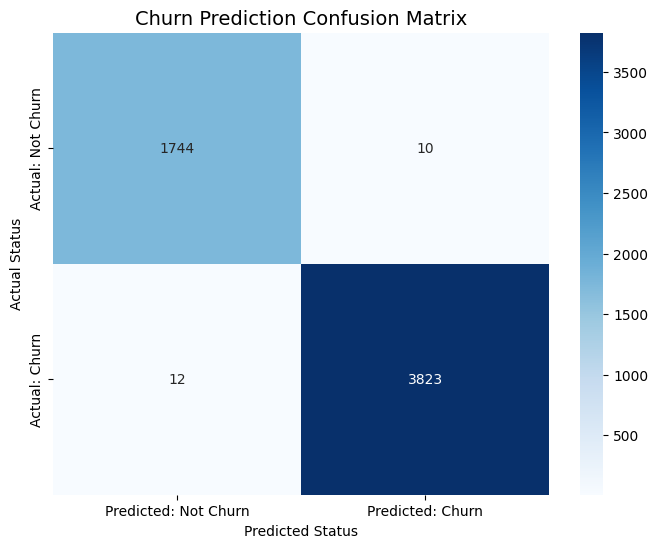

In [5]:
#10 - Customer Churn Prediction
if 'df_cleaned' in locals():
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
    from xgboost import XGBClassifier
    import datetime as dt
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np
    sales_data = df_cleaned[df_cleaned['total_inclusive'] > 0].copy()
    sales_data['document_date'] = pd.to_datetime(sales_data['document_date'])
    CHURN_WINDOW_DAYS = 180
    snapshot_date = sales_data['document_date'].max() + dt.timedelta(days=1)
    customer_df = sales_data.groupby('client_id').agg(
        recency=('document_date', lambda date: (snapshot_date - date.max()).days),
        frequency=('document_date', 'nunique'),
        monetary=('total_inclusive', 'sum'),
        first_purchase_date=('document_date', 'min')
    ).reset_index()

    customer_df['customer_lifetime_days'] = (snapshot_date - customer_df['first_purchase_date']).dt.days
    customer_df['avg_spend_per_visit'] = np.divide(
        customer_df['monetary'],
        customer_df['frequency'],
        out=np.zeros_like(customer_df['monetary']),
        where=(customer_df['frequency'] != 0)
    )
    features_to_use = ['recency', 'frequency', 'monetary', 'customer_lifetime_days', 'avg_spend_per_visit']
    for col in features_to_use:
        customer_df.replace([np.inf, -np.inf], 0, inplace=True)
        customer_df[col] = customer_df[col].fillna(0)
    customer_df['has_churned'] = (customer_df['recency'] > CHURN_WINDOW_DAYS).astype(int)
    X = customer_df[features_to_use]
    y = customer_df['has_churned']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    if (y_train == 1).sum() == 0:
        print("--- WARNING: No churned customers in the training set. Model cannot be trained. ---")
    else:
        scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
        model10_churn = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False,
                                     scale_pos_weight=scale_pos_weight, random_state=42)
        model10_churn.fit(X_train, y_train)
        y_pred = model10_churn.predict(X_test)
        print("          CUSTOMER CHURN PREDICTION REPORT")
        print(f"DEFINITION OF A 'CHURNED' CUSTOMER: No purchase in last {CHURN_WINDOW_DAYS} days.")
        report = classification_report(y_test, y_pred, target_names=['Did Not Churn', 'CHURNED'])
        print("\nDetailed Classification Report")
        print(report)
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Predicted: Not Churn', 'Predicted: Churn'],
                    yticklabels=['Actual: Not Churn', 'Actual: Churn'])
        plt.title('Churn Prediction Confusion Matrix', fontsize=14)
        plt.ylabel('Actual Status'); plt.xlabel('Predicted Status')
        plt.show()

In [6]:
#11 - Promotion Revenue Lift Prediction Model
if 'df_cleaned' in locals():
    from sklearn.model_selection import train_test_split
    from xgboost import XGBRegressor
    from sklearn.metrics import mean_squared_error
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    import pandas as pd
    import numpy as np
    sales_data = df_cleaned[df_cleaned['total_inclusive'] > 0].copy()
    sales_data['document_date'] = pd.to_datetime(sales_data['document_date'])
    promo_transactions = sales_data[sales_data['discount'] > 0].copy()
    promo_events = promo_transactions.groupby([
        'category',
        pd.Grouper(key='document_date', freq='W-MON')
    ]).agg(
        promo_revenue=('total_inclusive', 'sum'),
        avg_discount_pct=('discount', lambda x: (x / (df_cleaned.loc[x.index, 'total_inclusive'] + x)).mean() * 100)
    ).reset_index()
    weekly_revenue = sales_data.groupby(['category', pd.Grouper(key='document_date', freq='W-MON')])['total_inclusive'].sum().reset_index()
    weekly_revenue['baseline_revenue'] = weekly_revenue.groupby('category')['total_inclusive'].transform(lambda x: x.rolling(4, 1).mean().shift(1))
    promo_events_with_baseline = pd.merge(promo_events, weekly_revenue, on=['category', 'document_date'])
    promo_events_with_baseline['revenue_lift'] = (
        (promo_events_with_baseline['promo_revenue'] - promo_events_with_baseline['baseline_revenue']) /
        promo_events_with_baseline['baseline_revenue']
    ).fillna(0)
    promo_events_with_baseline.replace([np.inf, -np.inf], 0, inplace=True)
    features = ['avg_discount_pct', 'category', 'document_date']
    target = 'revenue_lift'

    model_df = promo_events_with_baseline[features + [target]].copy()
    model_df['month'] = model_df['document_date'].dt.month
    model_df.drop(columns='document_date', inplace=True)

    X = model_df.drop(columns=target)
    y = model_df[target]
    preprocessor = ColumnTransformer(transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['category'])
    ], remainder='passthrough')
    lift_predictor = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42))
    ])

    lift_predictor.fit(X, y)
    print("       PROMOTION REVENUE LIFT PREDICTION ENGINE")
    def predict_promotion_lift(discount, category, month):
        promo_data = pd.DataFrame([{
            'avg_discount_pct': discount,
            'category': category,
            'month': month
        }])
        predicted_lift = lift_predictor.predict(promo_data)[0]
        return predicted_lift
    lift1 = predict_promotion_lift(discount=15, category='Massage Collection', month=10)
    lift2 = predict_promotion_lift(discount=30, category='Beautiful Hands & Feet', month=12)
    lift3 = predict_promotion_lift(discount=40, category='Massage Collection', month=2)

    print("\nPROMOTION SIMULATOR")
    print(f"  > PREDICTED REVENUE LIFT: {lift1:+.1%}")

    print("\nScenario 2: 30% off 'Beautiful Hands & Feet' in December")
    print(f"  > PREDICTED REVENUE LIFT: {lift2:+.1%}")

    print("\nScenario 3: 40% off 'Massage Collection' in February")
    print(f"  > PREDICTED REVENUE LIFT: {lift3:+.1%}")

       PROMOTION REVENUE LIFT PREDICTION ENGINE

PROMOTION SIMULATOR
  > PREDICTED REVENUE LIFT: -85.1%

Scenario 2: 30% off 'Beautiful Hands & Feet' in December
  > PREDICTED REVENUE LIFT: -90.9%

Scenario 3: 40% off 'Massage Collection' in February
  > PREDICTED REVENUE LIFT: -72.9%


In [9]:
#12 - Predictive Employee Performance Model
if 'df_cleaned' in locals():
    from sklearn.model_selection import train_test_split
    from xgboost import XGBClassifier
    from sklearn.metrics import classification_report, accuracy_score
    import pandas as pd
    employee_data = df_cleaned.dropna(subset=['employee_names']).copy()
    employee_data = employee_data[employee_data['item_type'] == 'Spa']
    employee_data['employee_names'] = employee_data['employee_names'].str.split(r',\s*|\s+and\s+').str[0].str.strip() # Simplify to first employee for this model
    employee_data['document_date'] = pd.to_datetime(employee_data['document_date'])
    quarterly_performance = employee_data.groupby([
        'employee_names',
        pd.Grouper(key='document_date', freq='Q')
    ]).agg(
        total_revenue=('total_inclusive', 'sum'),
        services_performed=('description', 'count')
    ).reset_index()
    quarterly_performance.sort_values(['employee_names', 'document_date'], inplace=True)
    quarterly_performance['revenue_prev_q'] = quarterly_performance.groupby('employee_names')['total_revenue'].shift(1)
    quarterly_performance['services_prev_q'] = quarterly_performance.groupby('employee_names')['services_performed'].shift(1)
    quarterly_performance.rename(columns={'total_revenue': 'revenue_current_q'}, inplace=True)
    quarterly_performance.dropna(subset=['revenue_prev_q'], inplace=True)
    quantile_thresholds = quarterly_performance.groupby('document_date')['revenue_current_q'].transform(lambda x: x.quantile(0.80))
    quarterly_performance['is_top_performer'] = (quarterly_performance['revenue_current_q'] >= quantile_thresholds).astype(int)
    features = ['revenue_prev_q', 'services_prev_q']
    target = 'is_top_performer'

    X = quarterly_performance[features]
    y = quarterly_performance[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum() if (y_train == 1).sum() > 0 else 1

    employee_predictor = XGBClassifier(objective='binary:logistic', scale_pos_weight=scale_pos_weight, random_state=42)
    employee_predictor.fit(X_train, y_train)
    print("     PREDICTIVE EMPLOYEE PERFORMANCE REPORT")
    most_recent_data = quarterly_performance.loc[quarterly_performance.groupby('employee_names')['document_date'].idxmax()]
    features_for_prediction = most_recent_data[['revenue_current_q', 'services_performed']].rename(columns={
        'revenue_current_q': 'revenue_prev_q',
        'services_performed': 'services_prev_q'
    })
    prediction_proba = employee_predictor.predict_proba(features_for_prediction)[:, 1]
    prediction_report = most_recent_data[['employee_names']].copy()
    prediction_report['prob_of_being_top_performer'] = prediction_proba
    prediction_report = prediction_report.sort_values(by='prob_of_being_top_performer', ascending=False)

    print("\nPERFORMANCE FORECAST FOR NEXT QUARTER")
    print(prediction_report.to_string(index=False, formatters={'prob_of_being_top_performer': '{:.1%}'.format}))
    top_predicted = prediction_report.iloc[0]
    print(f"  - Focus on retaining and motivating high-probability employees like {top_predicted['employee_names']}.")

     PREDICTIVE EMPLOYEE PERFORMANCE REPORT

PERFORMANCE FORECAST FOR NEXT QUARTER
           employee_names prob_of_being_top_performer
           Jeto Phogojane                       96.9%
          Lister Mandunga                       94.9%
             Joyce Molemi                       88.9%
             Dorcas  Dube                       77.6%
          Panema Mthiyane                       77.6%
         Zanele Mkhatshwa                       69.7%
        Melody Muyendekwa                       45.8%
          Nteseng Mogaise                       43.3%
            Yvonne Makola                       31.7%
            Pinky Nxumalo                       31.3%
        Dimakatso Matladi                       31.2%
           Jetu Phogojane                       29.8%
             Zizo  Nohaji                       26.7%
             Rebone Kwadi                       22.5%
    Tshegofatso  Mosenogi                       10.5%
               Mary Phiri                        8.8%

In [10]:
#13 - Inventory Replenishment Alerts
if 'df_cleaned' in locals():
    from xgboost import XGBRegressor
    import numpy as np
    import pandas as pd
    import json
    import datetime as dt
    retail_products_df = df_cleaned[df_cleaned['item_type'] == 'Retail'].copy()
    top_retail_products = retail_products_df['description'].value_counts().nlargest(20).index.tolist()
    sales_data = retail_products_df[retail_products_df['description'].isin(top_retail_products)].copy()
    sales_data = sales_data[sales_data['total_inclusive'] > 0]
    sales_data['document_date'] = pd.to_datetime(sales_data['document_date'])
    weekly_demand = sales_data.groupby([
        'description', pd.Grouper(key='document_date', freq='W-MON')
    ]).agg(quantity_sold=('quantity', 'sum')).reset_index()

    weekly_demand['month'] = weekly_demand['document_date'].dt.month
    weekly_demand['week_of_year'] = weekly_demand['document_date'].dt.isocalendar().week
    weekly_demand.sort_values(by=['description', 'document_date'], inplace=True)
    weekly_demand['sales_lag_4_weeks'] = weekly_demand.groupby('description')['quantity_sold'].shift(4).fillna(0)

    model_data_encoded = pd.get_dummies(weekly_demand, columns=['description'], drop_first=False)
    X = model_data_encoded.drop(columns=['document_date', 'quantity_sold'])
    y = model_data_encoded['quantity_sold']

    demand_model = XGBRegressor(n_estimators=100, random_state=42).fit(X, y)
    np.random.seed(42)
    simulated_inventory = { product: np.random.randint(5, 40) for product in top_retail_products }
    last_date = weekly_demand['document_date'].max()
    future_weeks = pd.date_range(start=last_date, periods=5, freq='W-MON')[1:]

    forecast_list = []
    for product in top_retail_products:
        product_history = weekly_demand[weekly_demand['description'] == product]

        if not product_history.empty:
            last_lag = product_history['sales_lag_4_weeks'].iloc[-1]
        else:
            last_lag = 0

        for week_start in future_weeks:
            forecast_list.append({
                'description': product, 'document_date': week_start,
                'month': week_start.month, 'week_of_year': week_start.isocalendar().week,
                'sales_lag_4_weeks': last_lag
            })

    future_df = pd.DataFrame(forecast_list)
    future_df_encoded = pd.get_dummies(future_df, columns=['description'], drop_first=False)

    missing_cols = set(X.columns) - set(future_df_encoded.columns)
    for c in missing_cols: future_df_encoded[c] = 0
    future_df_encoded = future_df_encoded[X.columns]

    future_df['predicted_demand'] = demand_model.predict(future_df_encoded).round().astype(int)
    future_df.loc[future_df['predicted_demand'] < 0, 'predicted_demand'] = 0
    total_forecasted_demand = future_df.groupby('description')['predicted_demand'].sum()
    alerts = []
    SAFETY_STOCK_WEEKS = 2

    for product, demand_4_weeks in total_forecasted_demand.items():
        current_stock = simulated_inventory.get(product, 0)
        avg_weekly_demand = demand_4_weeks / 4
        recommended_stock_level = demand_4_weeks + (avg_weekly_demand * SAFETY_STOCK_WEEKS)

        if current_stock < recommended_stock_level:
            alerts.append({
                "product_name": product, "alert_level": "CRITICAL",
                "current_stock": int(current_stock), "predicted_4_week_demand": int(demand_4_weeks),
                "recommended_stock_level": int(recommended_stock_level),
                "chatbot_summary": (
                    f"CRITICAL replenishment alert for '{product}'. Your current stock is only {int(current_stock)} units. "
                    f"We PREDICT you will sell {int(demand_4_weeks)} units in the next 4 weeks. "
                    f"Recommend reordering immediately to reach a stock level of at least {int(recommended_stock_level)} units."
                )
            })

    print("     INVENTORY REPLENISHMENT ALERT SYSTEM")
    if not alerts:
        print("\n--- STATUS: OK ---")
        print("All stock levels are sufficient for the PREDICTED demand.")
    else:
        print("\nCRITICAL REPLENISHMENT ALERTS FOUND")
        alert_df = pd.DataFrame(alerts)
        print(alert_df[['product_name', 'current_stock', 'predicted_4_week_demand', 'recommended_stock_level']].to_string(index=False))
        print(json.dumps(alerts, indent=2))

     INVENTORY REPLENISHMENT ALERT SYSTEM

CRITICAL REPLENISHMENT ALERTS FOUND
                  product_name  current_stock  predicted_4_week_demand  recommended_stock_level
AW Cooling Recovery Gel - 30ml              7                        5                        7
               Eye & Lip Cream              6                        8                       12
[
  {
    "product_name": "AW Cooling Recovery Gel - 30ml",
    "alert_level": "CRITICAL",
    "current_stock": 7,
    "predicted_4_week_demand": 5,
    "recommended_stock_level": 7,
    "chatbot_summary": "CRITICAL replenishment alert for 'AW Cooling Recovery Gel - 30ml'. Your current stock is only 7 units. We PREDICT you will sell 5 units in the next 4 weeks. Recommend reordering immediately to reach a stock level of at least 7 units."
  },
  {
    "product_name": "Eye & Lip Cream",
    "alert_level": "CRITICAL",
    "current_stock": 6,
    "predicted_4_week_demand": 8,
    "recommended_stock_level": 12,
    "chatbot_summar

In [11]:
#14: Monthly Voucher Sales Forecasting
if 'df_cleaned' in locals():
    from xgboost import XGBRegressor
    import pandas as pd
    import json
    import datetime as dt
    voucher_sales = df_cleaned[df_cleaned['item_type'] == 'Voucher'].copy()
    voucher_sales = voucher_sales[voucher_sales['quantity'] > 0]

    monthly_vouchers = voucher_sales.groupby(pd.Grouper(key='document_date', freq='M')).agg(
        vouchers_sold=('quantity', 'sum')
    ).reset_index()
    monthly_vouchers['month'] = monthly_vouchers['document_date'].dt.month
    monthly_vouchers['year'] = monthly_vouchers['document_date'].dt.year
    for lag in [1, 2, 3]:
        monthly_vouchers[f'vouchers_lag_{lag}'] = monthly_vouchers['vouchers_sold'].shift(lag)
    monthly_vouchers['rolling_mean_3m'] = monthly_vouchers['vouchers_sold'].shift(1).rolling(window=3).mean()
    monthly_vouchers.dropna(inplace=True)
    if not monthly_vouchers.empty:
        features = ['month', 'year', 'vouchers_lag_1', 'vouchers_lag_2', 'vouchers_lag_3', 'rolling_mean_3m']
        target = 'vouchers_sold'
        X = monthly_vouchers[features]
        y = monthly_vouchers[target]

        voucher_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
        voucher_model.fit(X, y)
        future_forecasts = []
        recursive_preds = []
        last_known_data = monthly_vouchers.tail(1).iloc[0]
        last_date = last_known_data['document_date']

        for i in range(1, 4):
            next_month_date = last_date + pd.DateOffset(months=i)
            lag1 = last_known_data['vouchers_sold'] if i == 1 else recursive_preds[-1]
            lag2 = last_known_data['vouchers_lag_1'] if i == 1 else (last_known_data['vouchers_sold'] if i == 2 else recursive_preds[-2])
            lag3 = last_known_data['vouchers_lag_2'] if i == 1 else (last_known_data['vouchers_lag_1'] if i == 2 else (last_known_data['vouchers_sold'] if i == 3 else recursive_preds[-3]))
            rolling_mean = (lag1 + lag2 + lag3) / 3

            features_for_pred = pd.DataFrame([{'month': next_month_date.month,
                                               'year': next_month_date.year,
                                               'vouchers_lag_1': lag1, 'vouchers_lag_2': lag2,
                                               'vouchers_lag_3': lag3, 'rolling_mean_3m': rolling_mean}])

            prediction = voucher_model.predict(features_for_pred)[0]
            recursive_preds.append(prediction)
            future_forecasts.append({"forecast_period": next_month_date.strftime('%Y-%m'),
                                     "predicted_vouchers_sold": int(round(prediction))})
        print("     PREDICTIVE FORECAST: MONTHLY VOUCHER SALES")
        print("\nVoucher Sales Forecast for the Next 3 Months")

        report_df = pd.DataFrame(future_forecasts)
        print(report_df.to_string(index=False))

        print("\n\nCHATBOT KNOWLEDGE BASE (Voucher Forecast)")
        chatbot_output = {"forecast_type": "Monthly Voucher Sales",
                          "generated_on": dt.datetime.now().strftime("%Y-%m-%d"),
                          "forecasts": future_forecasts}
        print(json.dumps(chatbot_output, indent=2))

     PREDICTIVE FORECAST: MONTHLY VOUCHER SALES

Voucher Sales Forecast for the Next 3 Months
forecast_period  predicted_vouchers_sold
        2025-07                       40
        2025-08                       42
        2025-09                       50


CHATBOT KNOWLEDGE BASE (Voucher Forecast)
{
  "forecast_type": "Monthly Voucher Sales",
  "generated_on": "2025-06-26",
  "forecasts": [
    {
      "forecast_period": "2025-07",
      "predicted_vouchers_sold": 40
    },
    {
      "forecast_period": "2025-08",
      "predicted_vouchers_sold": 42
    },
    {
      "forecast_period": "2025-09",
      "predicted_vouchers_sold": 50
    }
  ]
}


In [12]:
#15: Monthly Guest Capture Rate Forecasting (Corrected for JSON TypeError)
if 'df_cleaned' in locals():
    from xgboost import XGBRegressor
    import pandas as pd
    import numpy as np
    import json
    import datetime as dt
    spa_guests_from_hotel = df_cleaned[df_cleaned['source'] == 'Hotel Guest'].copy()
    monthly_spa_guests = spa_guests_from_hotel.groupby(pd.Grouper(key='document_date', freq='M')).agg(captured_guests=('client_id', 'nunique')).reset_index()
    monthly_spa_guests['month_period'] = monthly_spa_guests['document_date'].dt.to_period('M')

    print("Simulating 'Total Hotel Guests' data to build a proof-of-concept model.")
    date_range = pd.date_range(start=df_cleaned['document_date'].min(), end=df_cleaned['document_date'].max(), freq='M')
    np.random.seed(42)
    base_guests = 1500
    seasonality = np.array([np.sin(x/12 * 2 * np.pi) * 500 for x in range(len(date_range))])
    random_noise = np.random.randint(-100, 100, size=len(date_range))
    total_hotel_guests = base_guests + seasonality + random_noise
    simulated_hotel_data = pd.DataFrame({'document_date': date_range, 'total_hotel_guests': total_hotel_guests})
    simulated_hotel_data['month_period'] = simulated_hotel_data['document_date'].dt.to_period('M')
    capture_rate_df = pd.merge(monthly_spa_guests, simulated_hotel_data[['month_period', 'total_hotel_guests']], on='month_period')
    capture_rate_df['capture_rate'] = (capture_rate_df['captured_guests'] / capture_rate_df['total_hotel_guests']) * 100
    capture_rate_df['month'] = capture_rate_df['document_date'].dt.month
    for lag in [1, 2, 3]: capture_rate_df[f'rate_lag_{lag}'] = capture_rate_df['capture_rate'].shift(lag)
    capture_rate_df.dropna(inplace=True)

    if not capture_rate_df.empty:
        features = ['month', 'rate_lag_1', 'rate_lag_2', 'rate_lag_3']
        target = 'capture_rate'
        X = capture_rate_df[features]
        y = capture_rate_df[target]
        capture_rate_model = XGBRegressor(n_estimators=100, random_state=42).fit(X, y)
        future_forecasts = []
        recursive_preds = []
        last_known_data = capture_rate_df.tail(1).iloc[0]
        last_date = last_known_data['document_date']

        for i in range(1, 4):
            next_month_date = last_date + pd.DateOffset(months=i)
            lag1 = last_known_data['capture_rate'] if i == 1 else recursive_preds[-1]
            lag2 = last_known_data['rate_lag_1'] if i == 1 else lag1
            lag3 = last_known_data['rate_lag_2'] if i == 1 else lag2

            features_for_pred = pd.DataFrame([{'month': next_month_date.month, 'rate_lag_1': lag1, 'rate_lag_2': lag2, 'rate_lag_3': lag3}])
            prediction = capture_rate_model.predict(features_for_pred)[0]
            recursive_preds.append(prediction)
            future_forecasts.append({
                "forecast_period": next_month_date.strftime('%Y-%m'),
                "predicted_capture_rate_pct": round(float(prediction), 2)
            })
        print("    PREDICTIVE FORECAST: MONTHLY SPA GUEST CAPTURE RATE")
        report_df = pd.DataFrame(future_forecasts)
        print(report_df.to_string(index=False))

        print("\n\nCHATBOT KNOWLEDGE BASE (Capture Rate Forecast)")
        chatbot_output = {"forecast_type": "Monthly Guest Capture Rate",
                          "generated_on": dt.datetime.now().strftime("%Y-%m-%d"),
                          "forecasts": future_forecasts}
        print(json.dumps(chatbot_output, indent=2))

Simulating 'Total Hotel Guests' data to build a proof-of-concept model.
    PREDICTIVE FORECAST: MONTHLY SPA GUEST CAPTURE RATE
forecast_period  predicted_capture_rate_pct
        2025-06                       21.97
        2025-07                       21.30
        2025-08                       30.94


CHATBOT KNOWLEDGE BASE (Capture Rate Forecast)
{
  "forecast_type": "Monthly Guest Capture Rate",
  "generated_on": "2025-06-26",
  "forecasts": [
    {
      "forecast_period": "2025-06",
      "predicted_capture_rate_pct": 21.97
    },
    {
      "forecast_period": "2025-07",
      "predicted_capture_rate_pct": 21.3
    },
    {
      "forecast_period": "2025-08",
      "predicted_capture_rate_pct": 30.94
    }
  ]
}


In [14]:
#16: Monthly Online Booking Rate Forecasting
if 'df_cleaned' in locals():
    from xgboost import XGBRegressor
    import pandas as pd
    import numpy as np
    import json
    import datetime as dt
    booking_events = df_cleaned.drop_duplicates(subset=['accounting_document_id']).copy()
    total_bookings = booking_events.groupby(pd.Grouper(key='document_date', freq='M')).agg(
        total_bookings=('accounting_document_id', 'count')
    ).reset_index()

    online_bookings = booking_events[booking_events['online'] == True].groupby(pd.Grouper(key='document_date', freq='M')).agg(
        online_bookings=('accounting_document_id', 'count')
    ).reset_index()
    booking_rate_df = pd.merge(total_bookings, online_bookings, on='document_date', how='left').fillna(0)
    booking_rate_df['online_booking_rate'] = (booking_rate_df['online_bookings'] / booking_rate_df['total_bookings']) * 100
    booking_rate_df['month'] = booking_rate_df['document_date'].dt.month
    for lag in [1, 2, 3]:
        booking_rate_df[f'rate_lag_{lag}'] = booking_rate_df['online_booking_rate'].shift(lag)
    booking_rate_df.dropna(inplace=True)

    if not booking_rate_df.empty:
        features = ['month', 'rate_lag_1', 'rate_lag_2', 'rate_lag_3']
        target = 'online_booking_rate'
        X = booking_rate_df[features]
        y = booking_rate_df[target]

        online_rate_model = XGBRegressor(n_estimators=100, random_state=42).fit(X, y)
        future_forecasts = []
        recursive_preds = []
        last_known_data = booking_rate_df.tail(1).iloc[0]
        last_date = last_known_data['document_date']

        for i in range(1, 4):
            next_month_date = last_date + pd.DateOffset(months=i)
            lag1 = last_known_data['online_booking_rate'] if i == 1 else recursive_preds[-1]
            lag2 = last_known_data['rate_lag_1'] if i == 1 else lag1
            lag3 = last_known_data['rate_lag_2'] if i == 1 else lag2

            features_for_pred = pd.DataFrame([{'month': next_month_date.month, 'rate_lag_1': lag1, 'rate_lag_2': lag2, 'rate_lag_3': lag3}])
            prediction = online_rate_model.predict(features_for_pred)[0]
            recursive_preds.append(prediction)

            future_forecasts.append({
                "forecast_period": next_month_date.strftime('%Y-%m'),
                "predicted_online_booking_rate_pct": round(float(prediction), 2)
            })
        print("      PREDICTIVE FORECAST: MONTHLY ONLINE BOOKING RATE")
        report_df = pd.DataFrame(future_forecasts)
        print(report_df.to_string(index=False))

        print("\n\nOnline Booking Rate Forecast)")
        chatbot_output = {
            "forecast_type": "Monthly Online Booking Rate",
            "generated_on": dt.datetime.now().strftime("%Y-%m-%d"),
            "forecasts": future_forecasts
        }
        print(json.dumps(chatbot_output, indent=2))
    else:
        print("Not enough historical data to calculate online booking rate")

      PREDICTIVE FORECAST: MONTHLY ONLINE BOOKING RATE
forecast_period  predicted_online_booking_rate_pct
        2025-07                               1.41
        2025-08                               1.52
        2025-09                               1.25


Online Booking Rate Forecast)
{
  "forecast_type": "Monthly Online Booking Rate",
  "generated_on": "2025-06-26",
  "forecasts": [
    {
      "forecast_period": "2025-07",
      "predicted_online_booking_rate_pct": 1.41
    },
    {
      "forecast_period": "2025-08",
      "predicted_online_booking_rate_pct": 1.52
    },
    {
      "forecast_period": "2025-09",
      "predicted_online_booking_rate_pct": 1.25
    }
  ]
}


In [15]:
#17: Predicting Total Spend of a New Guest (Corrected for NameError)
if 'df_cleaned' in locals():
    from xgboost import XGBRegressor
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_absolute_error
    from sklearn.preprocessing import StandardScaler, OneHotEncoder # <-- ADDED
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    import pandas as pd
    import json
    import datetime as dt
    sales_data = df_cleaned[df_cleaned['total_inclusive'] > 0].copy()

    first_purchase_dates = sales_data.groupby('client_id')['document_date'].min().reset_index()
    first_purchase_dates.rename(columns={'document_date': 'first_purchase_date'}, inplace=True)

    sales_data_with_start = pd.merge(sales_data, first_purchase_dates, on='client_id')
    sales_data_with_start['days_since_first_purchase'] = (sales_data_with_start['document_date'] - sales_data_with_start['first_purchase_date']).dt.days
    first_day_transactions = sales_data_with_start[sales_data_with_start['days_since_first_purchase'] == 0]
    first_day_features = first_day_transactions.groupby('client_id').agg(
        first_day_spend=('total_inclusive', 'sum'),
        first_day_items=('quantity', 'sum'),
        first_item_category=('category', 'first'),
        customer_source=('source', 'first')
    ).reset_index()
    first_90_days_sales = sales_data_with_start[sales_data_with_start['days_since_first_purchase'] <= 90]
    target_spend = first_90_days_sales.groupby('client_id')['total_inclusive'].sum().reset_index()
    target_spend.rename(columns={'total_inclusive': 'total_spend_first_90_days'}, inplace=True)
    model_df = pd.merge(first_day_features, target_spend, on='client_id')
    if not model_df.empty:
        X = model_df.drop(columns=['client_id', 'total_spend_first_90_days'])
        y = model_df['total_spend_first_90_days']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        categorical_features = ['first_item_category', 'customer_source']
        numeric_features = ['first_day_spend', 'first_day_items']

        X_train[categorical_features] = X_train[categorical_features].fillna('Unknown')
        X_test[categorical_features] = X_test[categorical_features].fillna('Unknown')

        preprocessor = ColumnTransformer(transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])

        spend_predictor = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42))
        ])

        spend_predictor.fit(X_train, y_train)
        y_pred = spend_predictor.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        print("    PREDICTIVE MODEL: NEW GUEST 90-DAY SPEND FORECAST")
        print(f" {mae:,.2f} currency units.")
        def predict_new_guest_spend(spend, items, category, source):
            guest_data = pd.DataFrame([{'first_day_spend': spend, 'first_day_items': items,
                                        'first_item_category': category, 'customer_source': source}])
            prediction = spend_predictor.predict(guest_data)[0]
            return float(prediction)

        pred1 = predict_new_guest_spend(spend=800, items=1, category='Massage Collection', source='Social Media')
        pred2 = predict_new_guest_spend(spend=2500, items=3, category='Skincare', source='Hotel Guest')

        print("\nNEW GUEST SPEND SIMULATOR")
        print(f"  > PREDICTED 90-DAY SPEND: {pred1:,.2f}")
        print(f"  > PREDICTED 90-DAY SPEND: {pred2:,.2f}")

        print("\n\n CHATBOT-(New Guest Spend Predictor)")
        chatbot_output = {
            "model_name": "New Guest 90-Day Spend Predictor",
            "description": "Predicts future spend based on a customer's first visit.",
            "mae_performance": round(mae, 2),
            "example_predictions": [
                {"scenario": "Social Media Guest, 800 spend", "predicted_90_day_spend": round(pred1, 2)},
                {"scenario": "Hotel Guest, 2500 spend", "predicted_90_day_spend": round(pred2, 2)}
            ]
        }
        print(json.dumps(chatbot_output, indent=2))
    else:
        print("--- ANALYSIS SKIPPED: Not enough historical data to build this model. ---")

    PREDICTIVE MODEL: NEW GUEST 90-DAY SPEND FORECAST
 325.38 currency units.

NEW GUEST SPEND SIMULATOR
  > PREDICTED 90-DAY SPEND: 981.89
  > PREDICTED 90-DAY SPEND: 2,596.36


 CHATBOT-(New Guest Spend Predictor)
{
  "model_name": "New Guest 90-Day Spend Predictor",
  "description": "Predicts future spend based on a customer's first visit.",
  "mae_performance": 325.38,
  "example_predictions": [
    {
      "scenario": "Social Media Guest, 800 spend",
      "predicted_90_day_spend": 981.89
    },
    {
      "scenario": "Hotel Guest, 2500 spend",
      "predicted_90_day_spend": 2596.36
    }
  ]
}


In [16]:
#18: Predicting Retail Spend of a New Guest (First 90 Days)
if 'df_cleaned' in locals():
    from xgboost import XGBRegressor
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_absolute_error
    from sklearn.preprocessing import StandardScaler, OneHotEncoder
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    import pandas as pd
    import json
    import datetime as dt
    sales_data = df_cleaned[df_cleaned['total_inclusive'] > 0].copy()

    first_purchase_dates = sales_data.groupby('client_id')['document_date'].min().reset_index()
    first_purchase_dates.rename(columns={'document_date': 'first_purchase_date'}, inplace=True)

    sales_data_with_start = pd.merge(sales_data, first_purchase_dates, on='client_id')
    sales_data_with_start['days_since_first_purchase'] = (sales_data_with_start['document_date'] - sales_data_with_start['first_purchase_date']).dt.days
    first_day_transactions = sales_data_with_start[sales_data_with_start['days_since_first_purchase'] == 0]
    first_day_features = first_day_transactions.groupby('client_id').agg(
        first_day_spend=('total_inclusive', 'sum'),
        first_day_items=('quantity', 'sum'),
        first_item_category=('category', 'first'),
        customer_source=('source', 'first')
    ).reset_index()
    first_90_days_sales = sales_data_with_start[sales_data_with_start['days_since_first_purchase'] <= 90]
    first_90_days_retail = first_90_days_sales[first_90_days_sales['item_type'] == 'Retail']
    target_retail_spend = first_90_days_retail.groupby('client_id')['total_inclusive'].sum().reset_index()
    target_retail_spend.rename(columns={'total_inclusive': 'retail_spend_first_90_days'}, inplace=True)
    model_df = pd.merge(first_day_features, target_retail_spend, on='client_id', how='left')
    model_df['retail_spend_first_90_days'].fillna(0, inplace=True)

    X = model_df.drop(columns=['client_id', 'retail_spend_first_90_days'])
    y = model_df['retail_spend_first_90_days']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    categorical_features = ['first_item_category', 'customer_source']
    numeric_features = ['first_day_spend', 'first_day_items']
    X_train[categorical_features] = X_train[categorical_features].fillna('Unknown')
    X_test[categorical_features] = X_test[categorical_features].fillna('Unknown')

    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

    retail_spend_predictor = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42))
    ])

    retail_spend_predictor.fit(X_train, y_train)
    y_pred = retail_spend_predictor.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)

    print("   PREDICTIVE MODEL: NEW GUEST 90-DAY RETAIL SPEND FORECAST")
    print(f"{mae:,.2f} currency units.")
    def predict_new_guest_retail_spend(spend, items, category, source):
        guest_data = pd.DataFrame([{'first_day_spend': spend, 'first_day_items': items,
                                    'first_item_category': category, 'customer_source': source}])
        prediction = retail_spend_predictor.predict(guest_data)[0]
        return float(prediction)
    pred1 = predict_new_guest_retail_spend(spend=800, items=1, category='Massage Collection', source='Social Media')
    pred2 = predict_new_guest_retail_spend(spend=1200, items=1, category='Facial Treatments', source='Hotel Guest')

    print("\nNEW GUEST RETAIL SPEND SIMULATOR ")
    print(f"  > PREDICTED 90-DAY RETAIL SPEND: {pred1:,.2f}")
    print(f"  > PREDICTED 90-DAY RETAIL SPEND: {pred2:,.2f}")

   PREDICTIVE MODEL: NEW GUEST 90-DAY RETAIL SPEND FORECAST
172.52 currency units.

NEW GUEST RETAIL SPEND SIMULATOR 
  > PREDICTED 90-DAY RETAIL SPEND: 17.23
  > PREDICTED 90-DAY RETAIL SPEND: 18.71


In [17]:
#19: Predicting if a New Guest will Buy Retail (Classification)
if 'df_cleaned' in locals():
    from xgboost import XGBClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score, classification_report
    from sklearn.preprocessing import StandardScaler, OneHotEncoder
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    import pandas as pd
    import json
    import datetime as dt
    sales_data = df_cleaned[df_cleaned['total_inclusive'] > 0].copy()
    first_purchase_dates = sales_data.groupby('client_id')['document_date'].min().reset_index()
    first_purchase_dates.rename(columns={'document_date': 'first_purchase_date'}, inplace=True)
    sales_data_with_start = pd.merge(sales_data, first_purchase_dates, on='client_id')
    sales_data_with_start['days_since_first_purchase'] = (sales_data_with_start['document_date'] - sales_data_with_start['first_purchase_date']).dt.days

    first_day_transactions = sales_data_with_start[sales_data_with_start['days_since_first_purchase'] == 0]
    first_day_features = first_day_transactions.groupby('client_id').agg(
        first_day_spend=('total_inclusive', 'sum'),
        first_day_items=('quantity', 'sum'),
        first_item_category=('category', 'first'),
        customer_source=('source', 'first')
    ).reset_index()
    first_90_days_sales = sales_data_with_start[sales_data_with_start['days_since_first_purchase'] <= 90]
    retail_buyers = first_90_days_sales[first_90_days_sales['item_type'] == 'Retail']['client_id'].unique()
    first_day_features['bought_retail_in_90_days'] = first_day_features['client_id'].isin(retail_buyers).astype(int)
    model_df = first_day_features.copy()

    X = model_df.drop(columns=['client_id', 'bought_retail_in_90_days'])
    y = model_df['bought_retail_in_90_days']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    categorical_features = ['first_item_category', 'customer_source']
    numeric_features = ['first_day_spend', 'first_day_items']
    X_train[categorical_features] = X_train[categorical_features].fillna('Unknown')
    X_test[categorical_features] = X_test[categorical_features].fillna('Unknown')

    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

    retail_buyer_predictor = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(objective='binary:logistic', use_label_encoder=False, random_state=42))
    ])

    retail_buyer_predictor.fit(X_train, y_train)
    y_pred_proba = retail_buyer_predictor.predict_proba(X_test)[:, 1]
    accuracy = accuracy_score(y_test, y_pred_proba > 0.5)
    print("     PREDICTIVE MODEL: NEW GUEST RETAIL PURCHASE PROBABILITY")
    print(f"\nModel Performance (Accuracy): {accuracy:.2%}")
    def predict_retail_propensity(spend, items, category, source):
        guest_data = pd.DataFrame([{'first_day_spend': spend, 'first_day_items': items,
                                    'first_item_category': category, 'customer_source': source}])
        prediction_prob = retail_buyer_predictor.predict_proba(guest_data)[0, 1]
        return float(prediction_prob)
    prob1 = predict_retail_propensity(spend=800, items=1, category='Massage Collection', source='Social Media')
    prob2 = predict_retail_propensity(spend=1000, items=1, category='Gift Vouchers', source='Walk-in')

    print("\nNEW GUEST RETAIL PROPENSITY SIMULATOR")
    print(f"  > PREDICTED PROBABILITY of buying retail soon: {prob1:.1%}")
    print(f"  > PREDICTED PROBABILITY of buying retail soon: {prob2:.1%}")

     PREDICTIVE MODEL: NEW GUEST RETAIL PURCHASE PROBABILITY

Model Performance (Accuracy): 91.12%

NEW GUEST RETAIL PROPENSITY SIMULATOR
  > PREDICTED PROBABILITY of buying retail soon: 1.6%
  > PREDICTED PROBABILITY of buying retail soon: 1.3%
